In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

# Separate the data into DataLoaders

In [3]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

# Create the Model and a training 

In [4]:
class theModelClass(nn.Module):
  def __init__(self,dropoutRate):
    super().__init__()

    ### layers
    self.input  = nn.Linear( 4,12)
    self.hidden = nn.Linear(12,12)
    self.output = nn.Linear(12, 3)

    # parameters
    self.dr = dropoutRate

  # forward pass
  def forward(self,x):

    # input
    x = F.relu( self.input(x) )
    x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()
    
    # hidden
    x = F.relu( self.hidden(x) )
    x = F.dropout(x,p=self.dr,training=self.training)
    
    # output
    x = self.output(x)
    return x

In [5]:
# test the model
tmpnet = theModelClass(.25)

# run some random data through
tmpdata = torch.randn((10,4))
yhat = tmpnet(tmpdata)
yhat

tensor([[-0.7572,  0.5089,  0.2610],
        [-0.0234,  0.4237,  0.4055],
        [-0.2324,  0.2296,  0.4219],
        [-0.0468,  0.2519,  0.2709],
        [-0.3307,  0.2808,  0.5305],
        [-0.2936,  0.2868,  0.1957],
        [-0.2223,  0.5182,  0.3057],
        [-0.2083,  0.3051,  0.5375],
        [-0.1655,  0.2539,  0.5025],
        [-0.6057,  0.4316,  0.5076]], grad_fn=<AddmmBackward>)

In [6]:
#a function that creates the ANN model

def createANewModel(dropoutrate):
    #grab an instance of the model class
    ANNiris = theModelClass(dropoutrate)
     # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005)

    return ANNiris,lossfun,optimizer


In [7]:
# train the model

# global parameter
numepochs = 500

def trainTheModel():

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch learning on
    ANNiris.train()

    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    ANNiris.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
  
  # function output
  return trainAcc,testAcc


# Now for the real work

In [8]:
# create a model
dropoutrate = .0
ANNiris,lossfun,optimizer = createANewModel(dropoutrate)

# train the model
trainAcc,testAcc = trainTheModel()

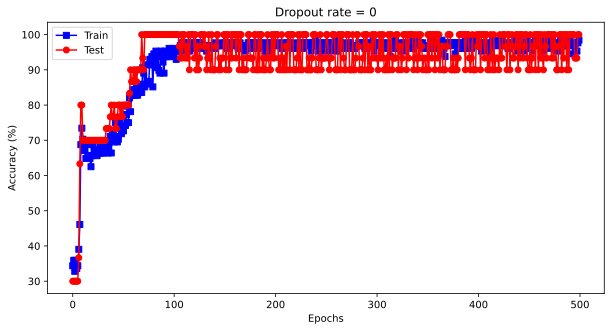

In [9]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()

In [10]:
# run an experiment

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

  # create and train the model
  ANNiris,lossfun,optimizer = createANewModel(dropoutRates[di])
  trainAcc,testAcc = trainTheModel()

  # store accuracies
  results[di,0] = np.mean(trainAcc[-50:])
  results[di,1] = np.mean(testAcc[-50:])

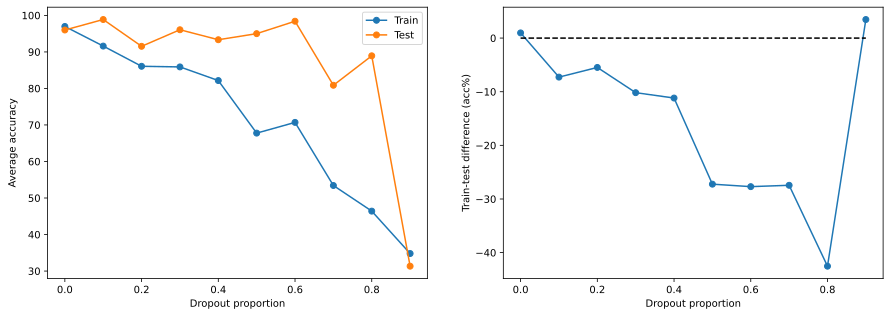

In [11]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()